# Partition Dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import copy
import scipy.io as sio

In [ ]:
def iid_divide(l, g):
    num_elems = len(l)
    group_size = int(len(l) / g)
    num_big_groups = num_elems - g * group_size
    num_small_groups = g - num_big_groups
    glist = []
    for i in range(num_small_groups):
        glist.append(l[group_size * i: group_size * (i + 1)])
    bi = group_size * num_small_groups
    group_size += 1
    for i in range(num_big_groups):
        glist.append(l[bi + group_size * i:bi + group_size * (i + 1)])
    return glist

In [ ]:
def pathological_non_iid_split(dataset, n_classes, n_clients, n_classes_per_client,seed=2025):
    np.random.seed(seed)
    data_idcs = list(range(len(dataset)))
    label2index = {k: [] for k in range(n_classes)}
    for idx in data_idcs:
        _, label = dataset[idx]
        label2index[label].append(idx)

    sorted_idcs = []
    for label in label2index:
        sorted_idcs += label2index[label]

    n_shards = n_clients * n_classes_per_client
    # 
    shards = iid_divide(sorted_idcs, n_shards)
    np.random.shuffle(shards)
    # 
    tasks_shards = iid_divide(shards, n_clients)

    clients_idcs = [[] for _ in range(n_clients)]
    for client_id in range(n_clients):
        for shard in tasks_shards[client_id]:

            clients_idcs[client_id] += shard
    return clients_idcs

In [4]:
def iid_split(dataset, n_classes, n_clients, seed=2025):
    np.random.seed(seed)
    clients_idcs = []
    train_labels = dataset.targets
    class_idc = [np.argwhere(train_labels == y).flatten().tolist() for y in range(n_classes)]
    class_idcs = []
    for i in range(n_classes):
        class_idcs += class_idc[i]    
    class_idcs = np.random.permutation(class_idcs)

    num_per_client = int(len(dataset) / n_clients)    
    for i in range(n_clients):
        client = []
        for j in range(num_per_client):
            client += [class_idcs[i*num_per_client + j]]
        clients_idcs.append(client)

    return clients_idcs

# def iid_split(dataset, n_classes, n_clients, seed=2025):
#     np.random.seed(seed)
#     perm = np.random.permutation(len(dataset))
    
    
    
#     clients_idcs = []
#     train_labels = dataset.targets
#     class_idc = [np.argwhere(train_labels == y).flatten().tolist() for y in range(n_classes)]
#     class_idcs = []
#     for i in range(n_classes):
#         class_idcs += class_idc[i]    
#     class_idcs = np.random.permutation(class_idcs)

#     num_per_client = int(len(dataset) / n_clients)    
#     for i in range(n_clients):
#         client = []
#         for j in range(num_per_client):
#             client += [class_idcs[i*num_per_client + j]]
#         clients_idcs.append(client)

    return clients_idcs

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.4914, 0.4822, 0.4465),   
                         (0.2023, 0.1994, 0.2010))   
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

100%|██████████| 170M/170M [00:19<00:00, 8.68MB/s] 


## IID

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


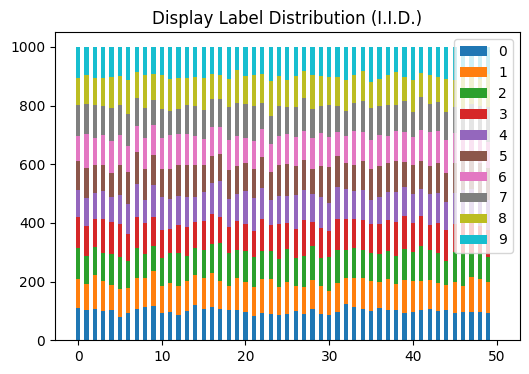

In [ ]:
n_classes = 10
n_clients = 50
classes = trainset.classes
n_classes = len(classes)
labels = trainset.targets

# seed = 123
seed = 2025
np.random.seed(seed)
num_per_client = int(len(trainset) / n_clients)
clients_idc = np.random.permutation(len(trainset))
clients_idcs=[]
for i in range(n_clients):
    clients_idcs.append(clients_idc[i*num_per_client : (i+1)*num_per_client])
# clients_idcs = iid_split(trainset, n_classes, n_clients,seed)


# 
plt.figure(figsize=(6, 4))
label_distribution = [[] for _ in range(n_classes)]
for c_id, idc in enumerate(clients_idcs):
    for idx in idc:
        label_distribution[labels[idx]].append(c_id)

plt.hist(label_distribution, stacked=True,
            bins=np.arange(-0.5, n_clients + 1.5, 1),
            label=range(n_classes), rwidth=0.5)
# plt.xticks(np.arange(n_clients), ["%d" %
                                    # (c_id+1) for c_id in range(n_clients)], fontsize=8)
# plt.xlabel("Client ID",fontsize=15)
# plt.ylabel("Number of samples",fontsize=15)
plt.legend(loc="upper right")
plt.title("Display Label Distribution (I.I.D.)")
plt.savefig('CIFAR10_distr_iid.eps', format="eps")
plt.show()

In [ ]:
clients = []
X = np.zeros((50000, 3072))
ncostterms = int(50000/n_clients)
for i in range(n_clients):
    for j in range(ncostterms):
        x, y = trainset[clients_idcs[i][j]]
        x = x.flatten().tolist()
        X[i*ncostterms+j, :] = x
sio.savemat(f'CIFAR10_train_{n_clients}_iid.mat', {'data':X, 'nagents': n_clients, 'ncostterms': ncostterms})

## NON-IID

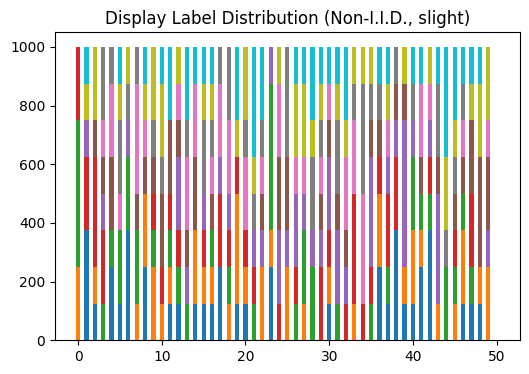

In [ ]:
n_clients = 50
# n_classes_per_client = 4  # heavy non-i.i.d
n_classes_per_client = 8    # slight non-i.i.d.
seed = 2025

classes = trainset.classes
n_classes = len(classes)

# labels = np.concatenate(
#     [np.array(trainset.targets), np.array(testset.targets)], axis=0)
# dataset = ConcatDataset([trainset, testset])

labels = trainset.targets


clients_idcs = pathological_non_iid_split(
    trainset, n_classes, n_clients, n_classes_per_client,seed)

# show local dataset distributions
plt.figure(figsize=(6, 4))
label_distribution = [[] for _ in range(n_classes)]
for c_id, idc in enumerate(clients_idcs):
    for idx in idc:
        label_distribution[labels[idx]].append(c_id)

plt.hist(label_distribution, stacked=True,
            bins=np.arange(-0.5, n_clients + 1.5, 1),
            label=range(n_classes), rwidth=0.5)

# plt.xticks(np.arange(n_clients), ["%d" %
                                    # (c_id+1) for c_id in range(n_clients)], fontsize=8)
# plt.xlabel("Client ID",fontsize=15)
# plt.ylabel("Number of samples",fontsize=15)
# plt.legend(loc="upper right")
plt.title("Display Label Distribution (Non-I.I.D., slight)")
# plt.title("Display Label Distribution (Non-I.I.D., heavy)")
plt.savefig('CIFAR10_distr_noniid_slight.eps', format="eps")
# plt.savefig('CIFAR10_distr_noniid_heavy.eps', format="eps")
plt.show()

In [26]:
clients = []
X = np.zeros((50000, 3072))
ncostterms = int(50000/n_clients)
for i in range(n_clients):    
    for j in range(len(clients_idcs[i])):
        x, y = trainset[clients_idcs[i][j]]
        x = np.array(x.flatten().tolist())
        X[i*ncostterms+j, :] = x
sio.savemat(f'CIFAR10_train_{n_clients}_noniid_slight.mat', {'data':X, 'nagents': n_clients, 'ncostterms': ncostterms})
# sio.savemat(f'CIFAR10_train_{n_clients}_noniid_large.mat', {'data':X, 'nagents': n_clients, 'ncostterms': ncostterms})

[1, 2]